# Model27: We are at the last chance!

In [109]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from utils import load_buzz, select, write_result
from features import featurize, get_pos
from containers import Questions, Users, Categories
from nlp import extract_entities

## KMeans

In [110]:
import pickle


questions = pickle.load(open('questions01.pkl', 'rb'))
users = pickle.load(open('users01.pkl', 'rb'))
categories = pickle.load(open('categories01.pkl', 'rb'))

In [111]:
load_buzz()['train'][1]

{'answer': 'cole', 'position': 61.0, 'qid': 1, 'uid': 0}

In [112]:
questions[1]

{'acc_ratio_qid': 0.875,
 'answer': 'thomas cole',
 'ave_pos_qid': 70.5,
 'cat_qid': '11',
 'category': 'Fine Arts',
 'group': 'test',
 'ne_count': 12,
 'ne_mean': 56.5,
 'ne_median': 60.5,
 'ne_mod': 65,
 'ne_nor_mean': 0.7243589743589743,
 'ne_tags': [['CD', '1840', 20],
  ['PERSON', 'Architect', 21],
  ['CD', 'three', 40],
  ['GPE', 'Europe', 44],
  ['CD', '1829', 46],
  ['CD', 'four', 56],
  ['ORGANIZATION', 'Hudson', 65],
  ['ORGANIZATION', 'Catskill', 69],
  ['ORGANIZATION', 'FTP', 72],
  ['ORGANIZATION', 'Oxbow', 79],
  ['ORGANIZATION', 'Voyage', 82],
  ['GPE', 'Life', 84]],
 'pos_token': {0: '',
  1: 'painters',
  2: 'indulgence',
  4: 'visual',
  5: 'fantasy',
  7: 'appreciation',
  9: 'different',
  10: 'historic',
  11: 'architectural',
  12: 'styles',
  15: 'seen',
  18: '1840',
  19: 'architects',
  20: 'dream',
  23: 'series',
  25: 'paintings',
  28: 'last',
  31: 'mohicans',
  33: 'made',
  35: 'three',
  36: 'year',
  37: 'trip',
  39: 'europe',
  41: '1829',
  45: 'be

In [113]:
set(users[0].keys()) - set(['cat_uid'])

{'acc_cat_astronomy',
 'acc_cat_biology',
 'acc_cat_chemistry',
 'acc_cat_earth science',
 'acc_cat_fine arts',
 'acc_cat_history',
 'acc_cat_literature',
 'acc_cat_mathematics',
 'acc_cat_other',
 'acc_cat_physics',
 'acc_cat_social studies',
 'acc_ratio_uid',
 'ave_pos_uid',
 'avg_pos_cat_astronomy',
 'avg_pos_cat_biology',
 'avg_pos_cat_chemistry',
 'avg_pos_cat_earth science',
 'avg_pos_cat_fine arts',
 'avg_pos_cat_history',
 'avg_pos_cat_literature',
 'avg_pos_cat_mathematics',
 'avg_pos_cat_other',
 'avg_pos_cat_physics',
 'avg_pos_cat_social studies'}

In [114]:
from sklearn.preprocessing import normalize

wanted_user_items = list(set(users[0].keys()) - set(['cat_uid']))
X_pos_uid = users.select(wanted_user_items)
unwanted_q_items = ['answer', 'category', 'group', 'ne_tags', 'question', 'pos_token', 'cat_qid']
wanted_q_items = list(set(questions[1].keys() - set(unwanted_q_items)))
X_pos_qid = questions.select(wanted_q_items)
X_pos_uid = normalize(X_pos_uid, norm='l1')
X_pos_qid = normalize(X_pos_qid, norm='l1')

In [115]:
print(X_pos_qid[0])
print(X_pos_uid[0])

[ 0.00233291  0.22705633  0.14055008  0.03864789  0.00281807  0.20934271
  0.18196713  0.00243513  0.19484976]
[ 0.00143896  0.0017134   0.07663876  0.00129222  0.11934122  0.00141804
  0.00156781  0.03021814  0.03508882  0.00094432  0.04683448  0.00158029
  0.08119869  0.00125304  0.12376331  0.15196841  0.12971213  0.00154073
  0.00321068  0.00158237  0.11142938  0.00188863  0.0731171   0.00125909]


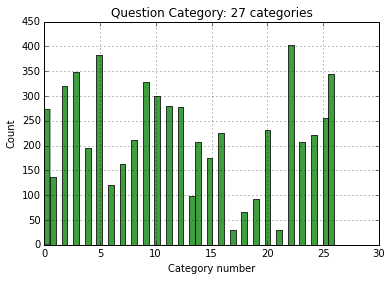

In [116]:
from sklearn.cluster import KMeans

# Question category
n_components = 27
est = KMeans(n_clusters=n_components)
est.fit(X_pos_qid)
pred_cat_qid = est.predict(X_pos_qid)

plt.hist(pred_cat_qid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("Question Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

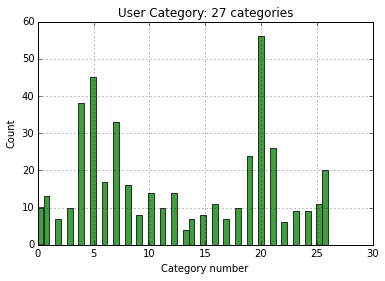

In [117]:
# User category
n_components = 27
est = KMeans(n_clusters=n_components)
est.fit(X_pos_uid)
pred_cat_uid = est.predict(X_pos_uid)

plt.hist(pred_cat_uid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("User Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

In [118]:
from collections import Counter


users.sub_append('cat_uid', {key: str(pred_cat_uid[i]) for i, key in enumerate(users.keys())})
questions.sub_append('cat_qid', {key: str(pred_cat_qid[i]) for i, key in enumerate(questions.keys())})

# to get most frequent cat for some test data which do not have ids in train set
most_pred_cat_uid = Counter(pred_cat_uid).most_common(1)[0][0]
most_pred_cat_qid = Counter(pred_cat_qid).most_common(1)[0][0]

print(most_pred_cat_uid)
print(most_pred_cat_qid)

20
22


## B. Modeling

In [119]:
def add_features(X):
    for item in X:
        # category
        for key in categories[item['category']].keys():
            item[key] = categories[item['category']][key]
            
        uid = int(item['uid'])
        qid = int(item['qid'])
        
        # uid
        if int(uid) in users:
            item.update(users[uid])
        else:
            acc = users.select(['acc_ratio_uid'])
            item['acc_ratio_uid'] = sum(acc) / float(len(acc))
            item['cat_uid'] = most_pred_cat_uid

        # qid
        if int(qid) in questions:
            item.update(questions[qid])

In [120]:
import pickle


questions = pickle.load(open('questions01.pkl', 'rb'))
users = pickle.load(open('users01.pkl', 'rb'))
categories = pickle.load(open('categories01.pkl', 'rb'))

In [121]:
from utils import load_buzz, select, write_result
from features import featurize, get_pos
from containers import Questions, Users, Categories
from nlp import extract_entities

import math
from collections import Counter

from numpy import abs, sqrt
from sklearn.linear_model import ElasticNetCV
from sklearn.cross_validation import ShuffleSplit, cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans


wanted_user_items = list(set(users[0].keys()) - set(['cat_uid']))
X_pos_uid = users.select(wanted_user_items)
unwanted_q_items = ['answer', 'category', 'group', 'ne_tags', 'question', 'pos_token', 'cat_qid']
wanted_q_items = list(set(questions[1].keys() - set(unwanted_q_items)))
X_pos_qid = questions.select(wanted_q_items)

X_pos_uid = normalize(X_pos_uid, norm='l1')
X_pos_qid = normalize(X_pos_qid, norm='l1')

tu = ('l1', 'n_uid_clust', 'n_qid_clust', 'rmse')
print ('=== Bench with ElasticNetCV: {0}, {1}, {2}, {3}'.format(*tu))
for ii in [27]:
    n_uid_clu = ii
    n_qid_clu = ii
    # clustering for uid
    uid_est = KMeans(n_clusters=n_uid_clu)
    uid_est.fit(X_pos_uid)
    pred_cat_uid = uid_est.predict(X_pos_uid)
    
    # clustering for qid
    qid_est = KMeans(n_clusters=n_qid_clu)
    qid_est.fit(X_pos_qid)
    pred_cat_qid = qid_est.predict(X_pos_qid)
    
    users.sub_append('cat_uid', {key: str(pred_cat_uid[i]) for i, key in enumerate(users.keys())})
    questions.sub_append('cat_qid', {key: str(pred_cat_qid[i]) for i, key in enumerate(questions.keys())})

    # to get most frequent cat for some test data which do not have ids in train set
    most_pred_cat_uid = Counter(pred_cat_uid).most_common(1)[0][0]
    most_pred_cat_qid = Counter(pred_cat_qid).most_common(1)[0][0]

    X_train, y_train = featurize(load_buzz(), group='train',
                                 sign_val=None, extra=['sign_val', 'avg_pos'])
    add_features(X_train)
    unwanted_features = ['ne_tags', 'pos_token', 'question', 'sign_val', 'group', 'q_acc_ratio_cat', 'q_ave_pos_cat']
    wanted_features = list(set(X_train[1].keys()) - set(unwanted_features))
    X_train = select(X_train, wanted_features)

    vec = DictVectorizer()
    X_train_dict_vec = vec.fit_transform(X_train)
    X_new = X_train_dict_vec
    #X_new = LinearSVC(C=0.01, penalty="l1", dual=False, random_state=50).fit_transform(X_train_dict_vec, y_train)
    n_samples = X_new.shape[0]
    cv = ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=50)
    print("L1-based feature selection:", X_train_dict_vec.shape, X_new.shape)
    for l1 in [0.7]:
        scores = cross_val_score(ElasticNetCV(n_jobs=3, normalize=True, l1_ratio = l1),
                                 X_new, y_train,
                                 cv=cv, scoring='mean_squared_error')
        rmse = sqrt(abs(scores)).mean()
        print ('{0}, {1}, {2}, {3}'.format(l1, n_uid_clu, n_qid_clu, rmse))

=== Bench with ElasticNetCV: l1, n_uid_clust, n_qid_clust, rmse
L1-based feature selection: (28494, 1123) (28494, 1123)
0.7, 27, 27, 74.77081707788457


In [122]:
X_train[125]

{'acc_cat_astronomy': 0.6666666666666666,
 'acc_cat_biology': 0.8055555555555556,
 'acc_cat_chemistry': 0.7297297297297297,
 'acc_cat_earth science': 1.0,
 'acc_cat_fine arts': 0.693069306930693,
 'acc_cat_history': 0.5428571428571428,
 'acc_cat_literature': 0.7315436241610739,
 'acc_cat_mathematics': 0.6666666666666666,
 'acc_cat_other': 0.75,
 'acc_cat_physics': 0.7297297297297297,
 'acc_cat_social studies': 0.7049180327868853,
 'acc_ratio_cat': 0.7560975609756098,
 'acc_ratio_qid': 1.0,
 'acc_ratio_uid': 0.701048951048951,
 'answer': 'henri matisse',
 'ave_pos_cat': 43.640185830429736,
 'ave_pos_qid': 96.166666666666671,
 'ave_pos_uid': 92.305944055944053,
 'avg_pos_cat_astronomy': 14.5,
 'avg_pos_cat_biology': 48.25,
 'avg_pos_cat_chemistry': 45.054054054054056,
 'avg_pos_cat_earth science': 76.0,
 'avg_pos_cat_fine arts': 33.039603960396036,
 'avg_pos_cat_history': 5.9,
 'avg_pos_cat_literature': 43.11409395973154,
 'avg_pos_cat_mathematics': 23.333333333333332,
 'avg_pos_cat_othe

Original
```
=== Bench with ElasticNetCV: l1, n_uid_clust, n_qid_clust, rmse
L1-based feature selection: (28494, 1112) (28494, 1112)
0.7, 27, 27, 74.88480204218828
```
Without users features for regression
```
=== Bench with ElasticNetCV: l1, n_uid_clust, n_qid_clust, rmse
L1-based feature selection: (28494, 1112) (28494, 1112)
0.7, 27, 27, 74.94733641570902
```

### Training and testing model

In [123]:
X_test = featurize(load_buzz(), group='test', sign_val=None, extra=['avg_pos'])
add_features(X_test)
X_test = select(X_test, wanted_features)

WARN: no key question
WARN: no key q_ave_pos_cat
WARN: no key group
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key q_acc_ratio_cat
WARN: no key question
WARN: no key q_ave_pos_cat
WARN: no key group
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key q_acc_ratio_cat
WARN: no key question
WARN: no key q_ave_pos_cat
WARN: no key group
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key q_acc_ratio_cat
WARN: no key question
WARN: no key q_ave_pos_cat
WARN: no key group
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key q_acc_ratio_cat
WARN: no key question
WARN: no key q_ave_pos_cat
WARN: no key group
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key q_acc_ratio_cat
WARN: no key question
WARN: no key q_ave_pos_cat
WARN: no key group
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key q_acc_ratio_cat
WARN: no key question
WARN: no key q_ave_pos_cat
WARN: no key group
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key q_acc_ratio_cat
WARN: no key 

In [124]:
unwanted_features = ['ne_tags', 'pos_token', 'question', 'sign_val', 'group', 'q_acc_ratio_cat', 'q_ave_pos_cat']
wanted_features = list(set(X_train[1].keys()) - set(unwanted_features))
X_train = select(X_train, wanted_features)
X_train[0]

{'acc_cat_astronomy': 0.6634615384615384,
 'acc_cat_biology': 0.5,
 'acc_cat_chemistry': 0.6842105263157895,
 'acc_cat_earth science': 1.0,
 'acc_cat_fine arts': 0.8367346938775511,
 'acc_cat_history': 0.8157894736842105,
 'acc_cat_literature': 0.9072164948453608,
 'acc_cat_mathematics': 0.6666666666666666,
 'acc_cat_other': 0.7508305647840532,
 'acc_cat_physics': 0.7619047619047619,
 'acc_cat_social studies': 0.8378378378378378,
 'acc_ratio_cat': 0.7560975609756098,
 'acc_ratio_qid': 0.875,
 'acc_ratio_uid': 0.8301282051282052,
 'answer': 'thomas cole',
 'ave_pos_cat': 43.640185830429736,
 'ave_pos_qid': 70.5,
 'ave_pos_uid': 80.464743589743591,
 'avg_pos_cat_astronomy': 24.798076923076923,
 'avg_pos_cat_biology': 1.7,
 'avg_pos_cat_chemistry': 18.57894736842105,
 'avg_pos_cat_earth science': 59.0,
 'avg_pos_cat_fine arts': 65.53061224489795,
 'avg_pos_cat_history': 40.578947368421055,
 'avg_pos_cat_literature': 68.68041237113403,
 'avg_pos_cat_mathematics': 16.0,
 'avg_pos_cat_other'

In [125]:
users[131]

{'acc_cat_astronomy': 0.0,
 'acc_cat_biology': 0.0,
 'acc_cat_chemistry': 0.4,
 'acc_cat_earth science': 0.7358490566037735,
 'acc_cat_fine arts': 0.75,
 'acc_cat_history': 0.5,
 'acc_cat_literature': 0.7368421052631579,
 'acc_cat_mathematics': 0.5,
 'acc_cat_other': 0.7508305647840532,
 'acc_cat_physics': 0.8181818181818182,
 'acc_cat_social studies': 0.7142857142857143,
 'acc_ratio_uid': 0.6712328767123288,
 'ave_pos_uid': 98.863013698630141,
 'avg_pos_cat_astronomy': -135.0,
 'avg_pos_cat_biology': -71.0,
 'avg_pos_cat_chemistry': -20.6,
 'avg_pos_cat_earth science': 36.509433962264154,
 'avg_pos_cat_fine arts': 47.75,
 'avg_pos_cat_history': 6.5,
 'avg_pos_cat_literature': 48.31578947368421,
 'avg_pos_cat_mathematics': -16.5,
 'avg_pos_cat_other': 42.993355481727576,
 'avg_pos_cat_physics': 73.63636363636364,
 'avg_pos_cat_social studies': 45.714285714285715,
 'cat_uid': '23'}

In [126]:
categories['astronomy']

{'acc_ratio_cat': 0.6634615384615384, 'ave_pos_cat': 24.798076923076923}

In [127]:
X_test[1]

{'acc_cat_astronomy': 0.0,
 'acc_cat_biology': 0.0,
 'acc_cat_chemistry': 0.4,
 'acc_cat_earth science': 0.7358490566037735,
 'acc_cat_fine arts': 0.75,
 'acc_cat_history': 0.5,
 'acc_cat_literature': 0.7368421052631579,
 'acc_cat_mathematics': 0.5,
 'acc_cat_other': 0.7508305647840532,
 'acc_cat_physics': 0.8181818181818182,
 'acc_cat_social studies': 0.7142857142857143,
 'acc_ratio_cat': 0.65625,
 'acc_ratio_qid': 0.6428571428571429,
 'acc_ratio_uid': 0.6712328767123288,
 'answer': 'david hilbert',
 'ave_pos_cat': 18.712499999999999,
 'ave_pos_qid': 79.857142857142861,
 'ave_pos_uid': 98.863013698630141,
 'avg_pos_cat_astronomy': -135.0,
 'avg_pos_cat_biology': -71.0,
 'avg_pos_cat_chemistry': -20.6,
 'avg_pos_cat_earth science': 36.509433962264154,
 'avg_pos_cat_fine arts': 47.75,
 'avg_pos_cat_history': 6.5,
 'avg_pos_cat_literature': 48.31578947368421,
 'avg_pos_cat_mathematics': -16.5,
 'avg_pos_cat_other': 42.993355481727576,
 'avg_pos_cat_physics': 73.63636363636364,
 'avg_pos_

In [128]:
vec = DictVectorizer()
vec.fit(X_train + X_test)
X_train = vec.transform(X_train)
X_test = vec.transform(X_test)

In [129]:
for l1_ratio in [0.7]:
    print('=== l1_ratio:', l1_ratio)
    regressor = ElasticNetCV(n_jobs=3, normalize=True, l1_ratio=l1_ratio, random_state=50)
    regressor.fit(X_train, y_train)
    print(regressor.coef_)
    print(regressor.alpha_)
    predictions = regressor.predict(X_test)
    write_result(load_buzz()['test'], predictions, file_name=str(l1_ratio)+'guess_adj.csv', adj=True)

=== l1_ratio: 0.7
[  0.00000000e+00   2.44614880e+00   1.16885070e+00 ...,   2.79331587e-02
   2.44484202e-06  -2.22299809e-03]
0.000404215283508
** Adjust results ***
** tid qid uid: pred_pos, q_length, diff
7952 5261 118 : 76.20704853129268 , 76 , 0.20704853129268486
32193 123840 15 : 33.13905495352259 , 33 , 0.13905495352258868
32186 123840 28 : 39.30250850371438 , 33 , 6.302508503714378
32081 123757 1 : 32.823092043553615 , 29 , 3.823092043553615
32067 123750 43 : 23.811646770260865 , 19 , 4.8116467702608645
32025 123718 39 : 14.589909377850944 , 13 , 1.5899093778509439
32018 123718 13 : 14.745953898007926 , 13 , 1.7459538980079259
31997 123709 52 : 32.99603995496645 , 17 , 15.996039954966449
14665 8933 56 : 65.59131446755626 , 58 , 7.591314467556259
13083 106213 9 : 33.687998402563196 , 21 , 12.687998402563196
12908 106060 124 : 39.63036477663594 , 37 , 2.6303647766359433
24990 106373 62 : 25.803181817113327 , 23 , 2.8031818171133267

** diff_tot 60.328113497038174


80.84596